# Bayesian Gaussian Process Latent Variable Model (Bayesian GPLVM)
This notebook shows how to use the Bayesian GPLVM model. This is an unsupervised learning method usually used for dimensionality reduction. For an in-depth overview of GPLVMs,see *[1, 2]*.

In [1]:
import gpflow
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Data
We are using the "three phase oil flow" dataset used initially for demonstrating the Generative Topographic mapping from *[3]*.

In [2]:
data = np.load('./data/three_phase_oil_flow.npz')
Y = data['Y']  # following the GPflow notation we assume this dataset has size [num_data, output_dim]
labels = data['labels']  # integer in [0, 2] indicating to which class the datapoint belongs [num_data,]. Not used for model fitting, only for plotting afterwards.

print('Number of points: {} and Number of dimensions: {}'.format(Y.shape[0], Y.shape[1]))

Number of points: 100 and Number of dimensions: 12


## Model construction

We start by initialising the required variables:

In [3]:
latent_dim = 2  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0]  # number of data points
X_mean_init = gpflow.models.PCA_reduce(Y, latent_dim)  # Initialise via PCA
X_var_init = np.ones((num_data, latent_dim))
Z_inducing_inputs_init = np.random.permutation(X_mean_init.copy())[:num_inducing]  # Pick inducing inputs randomly from dataset initialisation

We construct a Squared Exponential (SE) kernel operating on the two-dimensional latent space. 
The `ARD` parameter stands for Automatic Relevance Determination, which in practice means that
we learn a different lengthscale for each of the input dimensions. See [Manipulating kernels](../advanced/kernels.ipynb) for more information.

In [4]:
kernel = gpflow.kernels.RBF(latent_dim, ARD=True)

We have all the necessary ingredients to construct the model. GPflow contains an implementation of the Bayesian GPLVM:

In [5]:
m = gpflow.models.BayesianGPLVM(
    X_mean=X_mean_init,
    X_var=X_var_init,
    Y=Y,
    kern=kernel,
    M=num_inducing,
    Z=Z_inducing_inputs_init
)

# we change the default likelihood variance, which is 1, to 0.01.
m.likelihood.variance = 0.01

Next we optimise the created model. Given that this model has a deterministic evidence lower bound (ELBO), we can use SciPy's L-BFGS-B optimiser.

In [6]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -173.650389
  Number of iterations: 1309
  Number of functions evaluations: 1364


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -173.650389
  Number of iterations: 1309
  Number of functions evaluations: 1364


## Model analysis
GPflow allows you to inspect the learned model hyperparameters.

In [7]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/X_mean,Parameter,None,(none),True,"(100, 2)",True,"[[0.5335858726494092, -3.585462463168241], [-0..."
BayesianGPLVM/X_var,Parameter,None,+ve,True,"(100, 2)",True,"[[0.00025938337775691946, 0.002987260607075345..."
BayesianGPLVM/feature/Z,Parameter,None,(none),True,"(20, 2)",True,"[[0.723448722354364, 0.0216113992401794], [-1...."
BayesianGPLVM/kern/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[0.5724092125532642, 2.7044551950083004]"
BayesianGPLVM/kern/variance,Parameter,None,+ve,True,(),True,0.7480714466964397
BayesianGPLVM/likelihood/variance,Parameter,None,+ve,True,(),True,0.005255421275529302


## Plotting vs. Principle Component Analysis (PCA)
The reduction of the dimensionality of the dataset to two dimensions allows us to visualise the learned manifold.
We compare the Bayesian GPLVM's latent space to the deterministic PCA's one.

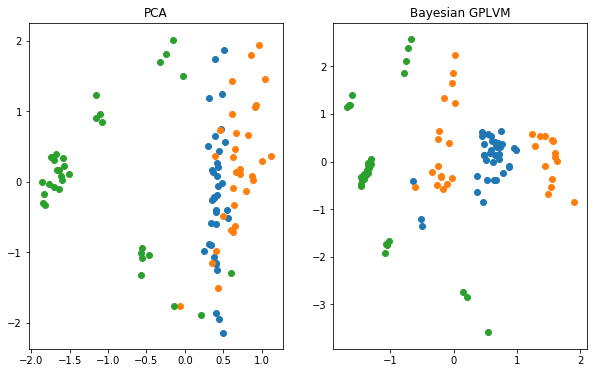

In [8]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
# when a model is trained we can access the values from the tensor as a `np.ndarray` using `read_value()`.
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1, 2, figsize=(10,6))

for i in np.unique(labels):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], label=i)
    ax[1].scatter(GPLVM_X_mean[labels==i, 0], GPLVM_X_mean[labels==i, 1], label=i)
    ax[0].set_title('PCA')
    ax[1].set_title('Bayesian GPLVM')
    

## References
\[1\] Lawrence, Neil D. 'Gaussian process latent variable models for visualisation of high dimensional data'. *Advances in Neural Information Processing Systems*. 2004.

\[2\] Titsias, Michalis, and Neil D. Lawrence. 'Bayesian Gaussian process latent variable model'. *Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics*. 2010.

\[3\] Bishop, Christopher M., and Gwilym D. James. 'Analysis of multiphase flows using dual-energy gamma densitometry and neural networks'. *Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment* 327.2-3 (1993): 580-593.